In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.ERROR)

01-Dec-19 18:49:58 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [4]:
def data_retrieval(train_filepath,test_filepath,response= RESPONSE):
    supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
    train_dataset,test_dataset = supervisedloader.load()
    return train_dataset,test_dataset



In [5]:
train_dataset,test_dataset =data_retrieval(train_filepath,test_filepath,RESPONSE)

In [6]:
def get_nullcounts(dataset):
    nullcount_frame = pd.DataFrame({'Feature':dataset.columns.values,
                                    'Missing_Values': dataset.shape[0] - dataset.count().values, })
    nullcount_frame = nullcount_frame[nullcount_frame['Missing_Values']>0].reset_index(drop=True)
    nullcount_frame['Missing_Values%'] = (nullcount_frame['Missing_Values']/dataset.shape[0])*100
    return nullcount_frame

In [7]:
def data_examination(train_dataset,test_dataset):
    display(train_dataset.info())
    display(test_dataset.info())
    display(get_nullcounts(train_dataset))
    display(get_nullcounts(test_dataset))
    display("training dataset- describe")
    display(train_dataset.describe())
    display("testing dataset- describe")
    display(test_dataset.describe())

In [8]:
#data_examination(train_dataset,test_dataset)
#import pandas_profiling
#pandas_profiling.ProfileReport(train_dataset)

#### What is promoted  vs not promoted  percentage ?

In [9]:
train_dataset['is_promoted'].value_counts(normalize=True)

0   0.9148
1   0.0852
Name: is_promoted, dtype: float64

In [10]:
train_dataset['new_feature'] = train_dataset['KPIs_met >80%'] + train_dataset['awards_won?']

In [11]:
train_dataset.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,new_feature
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0,1
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0,0


##### Impact of KPI_met by department wise on promotion

In [12]:
pd.pivot_table(train_dataset, index= 'department',
               columns= "is_promoted" ,
               aggfunc='count' ,
               values =['KPIs_met >80%'])

KPIs_met >80%      
is_promoted                   0     1
department                           
Analytics                  4840   512
Finance                    2330   206
HR                         2282   136
Legal                       986    53
Operations                10325  1023
Procurement                6450   688
R&D                         930    69
Sales & Marketing         15627  1213
Technology                 6370   768

In [37]:
train_dataset.groupby(['awards_won?','is_promoted'])['is_promoted'].agg({'Is_Promoted_Count':'count'})

Is_Promoted_Count
awards_won? is_promoted                   
0           0                        49429
            1                         4109
1           0                          711
            1                          559

In [14]:
groupby_cols =['department' ,'is_promoted']
aggs_col = 'previous_year_rating'
aggs_dict = {'previous_year_rating_median':'median'}
train_rating_by_department = train_dataset.groupby(groupby_cols)['previous_year_rating'].agg({'previous_year_rating_median':'median'}) 

In [15]:
train_rating_by_department

previous_year_rating_median
department        is_promoted                             
Analytics         0                                 3.0000
                  1                                 4.0000
Finance           0                                 3.0000
                  1                                 4.0000
HR                0                                 3.0000
                  1                                 4.0000
Legal             0                                 3.0000
                  1                                 5.0000
Operations        0                                 4.0000
                  1                                 4.0000
Procurement       0                                 3.0000
                  1                                 4.0000
R&D               0                                 3.0000
                  1                                 5.0000
Sales & Marketing 0                                 3.0000
                  1                                 4.0000
Technology        0                                 3.0000
                  1                                 4.0000

In [16]:
train_y = train_dataset['is_promoted']
train_dataset.drop(['employee_id'],axis=1,inplace=True)
test_employee_id = test_dataset['employee_id']
test_dataset.drop(['employee_id'],axis=1,inplace=True)

In [17]:
train_dataset.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,new_feature
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0,1
1,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0,0


In [18]:
#train_dataset.describe(include=['O'])

In [19]:
x = train_dataset.groupby(['is_promoted','education'])['is_promoted'].agg({'count'}).reset_index() 

In [20]:
no_of_trainings_df= train_dataset.groupby(['no_of_trainings','is_promoted'])['is_promoted'].agg({'count'}).reset_index()
no_of_trainings_df['count'] = np.log2(no_of_trainings_df['count'])
no_of_trainings_df

,no_of_trainings,is_promoted,count
0,1,0,15.3045
1,1,1,11.9330
2,2,0,12.8498
3,2,1,9.2408
4,3,0,10.6917
5,3,1,6.9307
6,4,0,8.7879
7,4,1,4.7004
8,5,0,6.9658
9,5,1,1.5850


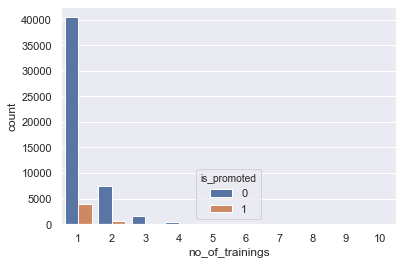

In [38]:
sns.countplot(x='no_of_trainings',hue = 'is_promoted' ,data =train_dataset)

In [62]:
#train_dataset.groupby(['region','is_promoted'])['is_promoted'].agg({'count'}).reset_index()
Promoted_Percent= pd.crosstab(train_dataset['region'], train_dataset['is_promoted'],margins=True).reset_index()
Promoted_Percent['Promoted_Percent'] = Promoted_Percent[1]/Promoted_Percent['All'] *100
Promoted_Percent =Promoted_Percent.sort_values(['Promoted_Percent'] )
Promoted_Percent

is_promoted,region,0,1,All,Promoted_Percent
33,region_9,412,8,420,1.9048
27,region_34,284,8,292,2.7397
9,region_18,30,1,31,3.2258
16,region_24,490,18,508,3.5433
26,region_33,259,10,269,3.7175
25,region_32,905,40,945,4.2328
21,region_29,951,43,994,4.3260
13,region_21,393,18,411,4.3796
29,region_5,731,35,766,4.5692
30,region_6,658,32,690,4.6377


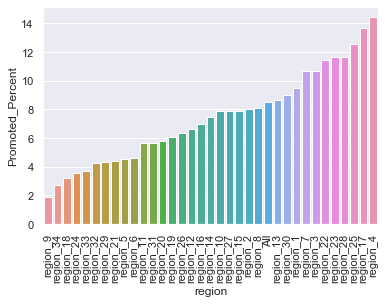

In [63]:
ax = sns.barplot(x='region', y="Promoted_Percent", data=Promoted_Percent)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [22]:
train_dataset.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,new_feature
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0,1
1,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0,0


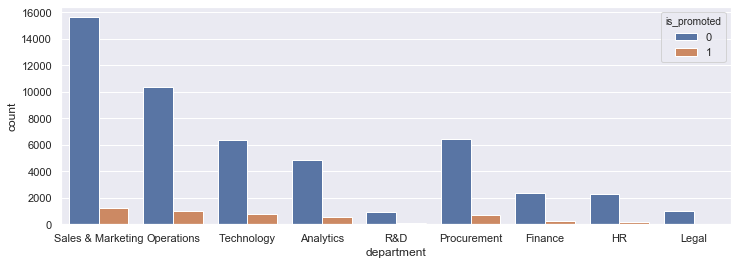

In [23]:
plt.figure(figsize=(12,4))
sns.countplot(x='department',hue = 'is_promoted' ,data =train_dataset)
plt.show()

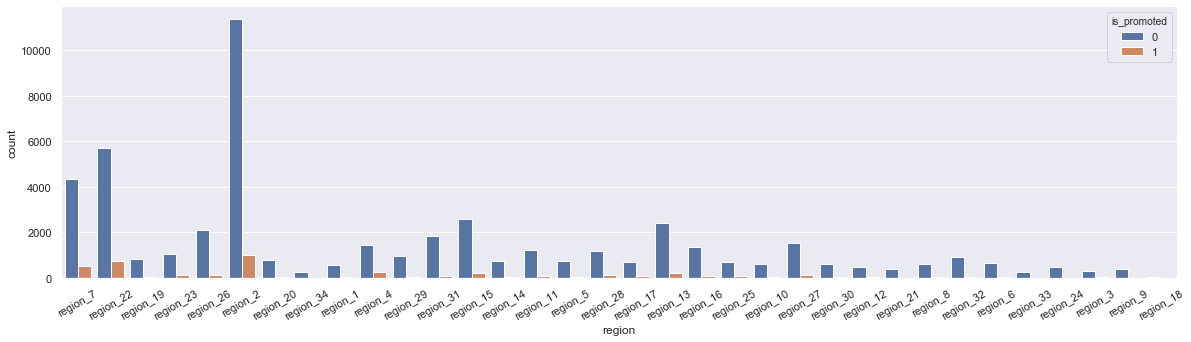

In [24]:
plt.figure(figsize=(20,5))
g =sns.countplot(x='region',hue = 'is_promoted' ,data =train_dataset)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
plt.show()

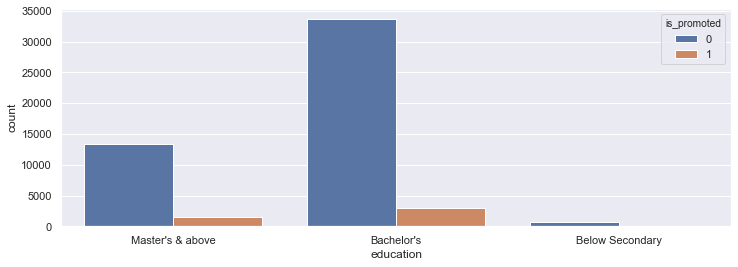

In [25]:
plt.figure(figsize=(12,4))
sns.countplot(x='education',hue = 'is_promoted' ,data =train_dataset)
plt.show()

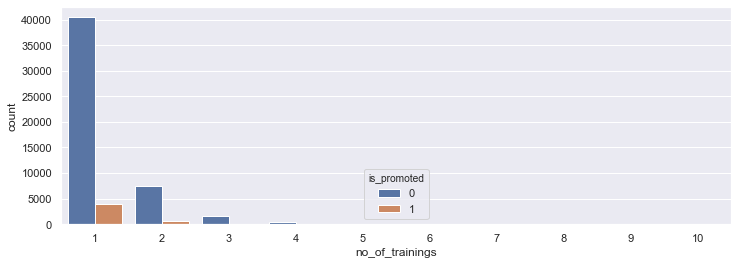

In [26]:
plt.figure(figsize=(12,4))
sns.countplot(x='no_of_trainings',hue = 'is_promoted' ,data =train_dataset)

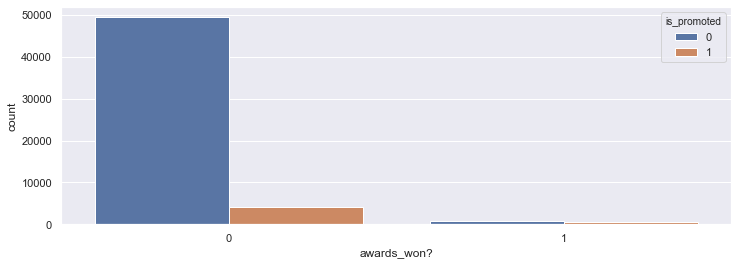

In [27]:
plt.figure(figsize=(12,4))
sns.countplot(x='awards_won?',hue = 'is_promoted' ,data =train_dataset)

In [28]:
train_dataset['No_Of_Training_>6'] = train_dataset['no_of_trainings'].apply(lambda x: 1 if x <6 else 0)

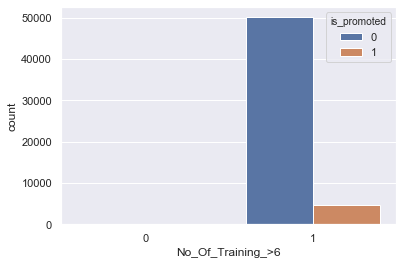

In [29]:
sns.countplot(x='No_Of_Training_>6',hue = 'is_promoted' ,data =train_dataset)

In [30]:
train_dataset[train_dataset['is_promoted']==1].head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,new_feature,No_Of_Training_>6
11,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0000,3,1,0,50,1,1,1
39,Sales & Marketing,region_28,Bachelor's,m,sourcing,1,33,5.0000,6,1,0,51,1,1,1
60,Sales & Marketing,region_4,Master's & above,m,other,1,50,4.0000,17,1,0,47,1,1,1
66,Finance,region_22,Bachelor's,m,other,1,27,nan,1,1,1,58,1,2,1
67,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,27,nan,1,0,0,61,1,0,1


In [31]:
train_dataset.describe(include =['object'])

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


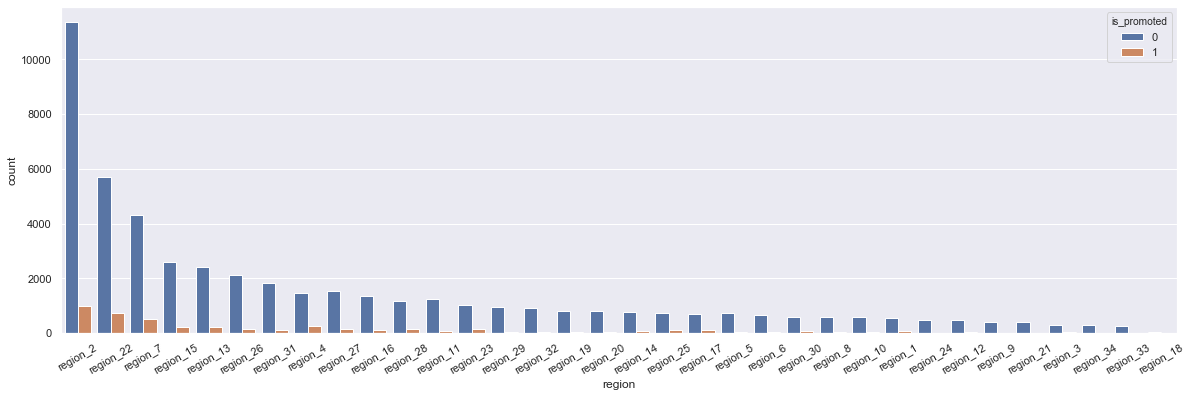

In [67]:
plt.figure(figsize=(20,6))
g = sns.countplot(x='region' ,hue ='is_promoted' ,data =train_dataset,
                  order = train_dataset['region'].value_counts().index,)
                 
g.set_xticklabels(g.get_xticklabels(),rotation=30 )
plt.show()

In [68]:
train_dataset.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,new_feature,No_Of_Training_>6
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0,1,1
1,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0,0,1
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0,0,1
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0,0,1
4,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0,0,1


In [94]:
groupby_age =train_dataset.groupby(['is_promoted',
                                    pd.cut(train_dataset['age'], bins=4)]
                                  )['age'].agg({'Age_mean':'mean',
                                                'Age_count':'count'
                                               }
                                              ).reset_index()

In [95]:
groupby_age 

,is_promoted,age,Age_mean,Age_count
0,0,"(19.96, 30.0]",27.5094,16568
1,0,"(30.0, 40.0]",34.7518,23669
2,0,"(40.0, 50.0]",44.5601,7242
3,0,"(50.0, 60.0]",54.8891,2661
4,1,"(19.96, 30.0]",27.6923,1550
5,1,"(30.0, 40.0]",34.7253,2359
6,1,"(40.0, 50.0]",44.3011,568
7,1,"(50.0, 60.0]",54.7120,191
